In [16]:
import numpy as np 
import pandas as pd
import os 
import sys 
import torch 
import torchaudio 
import matplotlib.pyplot as plt 
#%matplotlib_inline

import IPython.display as ipd

import torchaudio_functions as Audio
from torchaudio_functions import *

# Dataset Exploritory Analysis 

The RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) is a widely used dataset for emotion classification using recorded speech because of its high quality and consistent audio quality. The dataset can be found at https://smartlaboratory.org/ravdess/ and more info can be found in this offical citation from the creators: 

Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

RAVDESS contains both audio and video but for this project i will only be using and discussions the audio-only portion of the dataset. The database contains audio from 24 actors (12 male, 12 female) each speaking 2 similar sentences in a neutral North American accent. Each statement is spoken in 8 different emotions/ expressions (calm, happy, sad, angry, fearful, suprise, and disgust). Each one is performed in 2 different levels of emotional intensity (normal, strong) and a neutral expression is added. All audio recordings have a sample rate of 48kHz with a bit depth of 16bit. There is a total of 1440 audio files (24 actors X 60 trials per actor).


RAVDESS does not come with any sort of metadata table with information on the recordings but instead the filename themselves have all the information. Each filename has a 7 part numerical identifier (ex. 03-01-04-01-01-02-12.wav). The identifiers represent the following: 

    1.) Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    2.) Vocal channel (01 = speech, 02 = song).
    3.) Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    4.) Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
    5.) Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
    6.) Repetition (01 = 1st repetition, 02 = 2nd repetition).
    7.) Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So for example the file 03-01-04-01-01-02-12.wav contains the following metadata: 

    1.) Audio-only (03)
    2.) Speech (01)
    3.) Sad (04)
    4.) Normal Intensity (01)
    5.) "Kids are talking by the door" (01)
    6.) Second Repetition (02)
    7.) Actor-12 Male (12) 

# Creating Metadata table

To make the audio data easier to deal with I will create a Pandas data frame that will contain the file path of each audio file and linked to it's emotion as it will be are target variable. The audio files are each separated into their own folders by which actor performed them. 

In [17]:
audio_path = '/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/'

dir_list = os.listdir(audio_path)
dir_list.sort()

emotion = []
path = []
intensity = []
statement = []
actor = []
gender = []
for i in dir_list:
    fname = os.listdir(audio_path + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(audio_path + i + '/' + f)

        intent = int(part[3])
        if intent == 1:
            intent = "normal"
        else: 
            intent = "intense"
        intensity.append(intent)
        state = int(part[4])
        if state == 1:
            state = "Kids are talking by the door"
        else: 
            state = "Dogs are sitting by the door"
        statement.append(state)
        act = int(part[6])
        actor.append(act)


# dataframe for emotion of files
emotion_df = pd.DataFrame(emotion, columns=['Emotions'])

# dataframe for emotional intensity 
intensity_df = pd.DataFrame(intensity, columns=['Intensity'])

# dateframe for statements
statement_df = pd.DataFrame(statement, columns=['Statement'])

# dataframe for actor number 
actor_df = pd.DataFrame(actor, columns=['actor'])

# dataframe for path of files.
path_df = pd.DataFrame(path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df, intensity_df, statement_df, actor_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path,Intensity,Statement,actor
0,surprise,/Users/stephen/Emotion_Dectection/data/RAVDESS...,intense,Dogs are sitting by the door,1
1,surprise,/Users/stephen/Emotion_Dectection/data/RAVDESS...,normal,Kids are talking by the door,1
2,angry,/Users/stephen/Emotion_Dectection/data/RAVDESS...,normal,Dogs are sitting by the door,1
3,fear,/Users/stephen/Emotion_Dectection/data/RAVDESS...,normal,Dogs are sitting by the door,1
4,fear,/Users/stephen/Emotion_Dectection/data/RAVDESS...,intense,Kids are talking by the door,1


In [18]:
# Lets take a look at our target variables 
Ravdess_df['Emotions'].value_counts()

surprise    192
angry       192
fear        192
disgust     192
sad         192
happy       192
calm        192
neutral      96
Name: Emotions, dtype: int64

In [19]:
# export as csv 
Ravdess_df.to_csv('/Users/stephen/Emotion_Dectection/data/RAVDESS/metadata.csv')

The Dataset is all balanced except for the "neutral" emotion. This doesn't seem like it will be a problem so we'll leave it as is for now. 

# Visualizing the audio data
Here we'll use the Pytorch module torchaudio to convert the .wav files to tensor object so we can visualize the signal and then perform the necessary feature extractions to obtain data to train our model. 

In [20]:
# declare a variable that will locate a wav file to extract from 
angry_file_row = Ravdess_df.loc[Ravdess_df['Emotions'] == 'angry']
test_file_row = angry_file_row.iloc[0]
test_file_row

Emotions                                                 angry
Path         /Users/stephen/Emotion_Dectection/data/RAVDESS...
Intensity                                               normal
Statement                         Dogs are sitting by the door
actor                                                        1
Name: 2, dtype: object

Sample Rate: 48000
Shape: (1, 168168)
Dtype: torch.float32
 - Max:      0.110
 - Min:     -0.107
 - Mean:     0.000
 - Std Dev:  0.012

tensor([[ 0.0000e+00,  0.0000e+00, -3.0518e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])



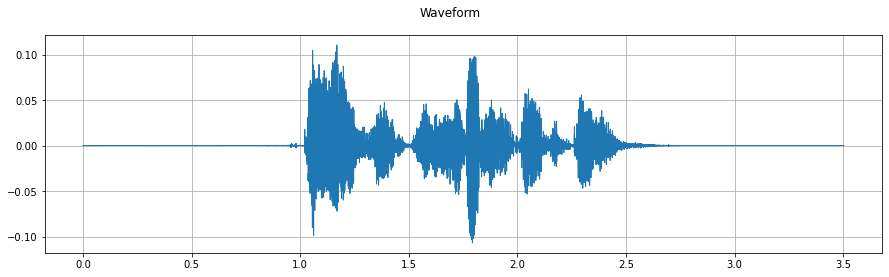

/Users/stephen/opt/anaconda3/envs/torch_env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


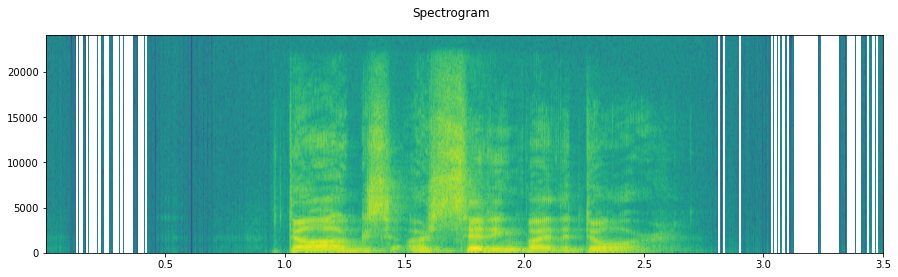

In [21]:
# based on Pytorch Documents 
# https://pytorch.org/tutorials/beginner/audio_feature_extractions_tutorial.html



# global variables 
n_fft = 2048
n_mels = 128
n_mfcc = 128
win_length = None 
hop_length = 512
sample_rate = None


# load audio file path to tenso 
waveform, sample_rate = torchaudio.load(test_file_row['Path'])

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate=sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

Shape: (1, 1025, 329)
Dtype: torch.float32
 - Max:     911.738
 - Min:      0.000
 - Mean:     0.112
 - Std Dev:  4.317

tensor([[[9.0198e-08, 5.3670e-07, 2.4289e-06,  ..., 8.3561e-06,
          7.3087e-07, 8.0265e-06],
         [1.7900e-08, 1.2830e-07, 3.6481e-06,  ..., 1.6383e-05,
          2.3724e-05, 5.4704e-06],
         [6.5044e-07, 8.5545e-07, 5.3769e-06,  ..., 2.2207e-05,
          4.5869e-05, 2.2536e-05],
         ...,
         [1.7075e-10, 1.3203e-09, 2.3185e-08,  ..., 5.8636e-08,
          7.1752e-08, 3.2709e-08],
         [1.8845e-08, 1.4223e-08, 1.3142e-08,  ..., 8.8826e-08,
          7.1109e-08, 1.4836e-09],
         [3.5984e-08, 8.0679e-09, 3.3830e-09,  ..., 1.0493e-07,
          5.0736e-08, 2.1360e-10]]])



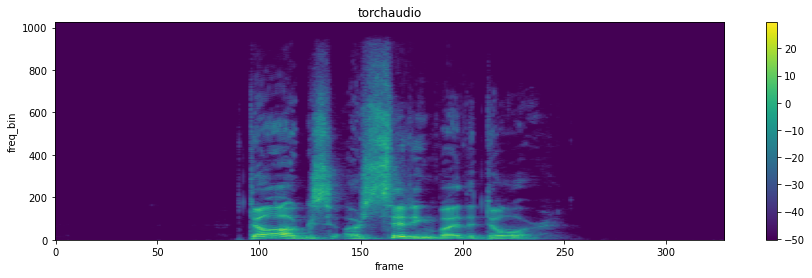

In [22]:
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(waveform)

print_stats(spec)
plot_spectrogram(spec[0], title='torchaudio')

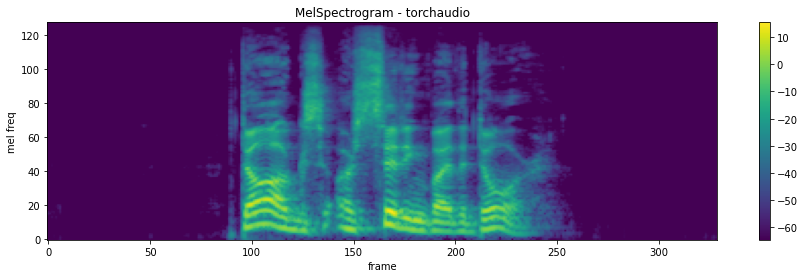

In [23]:
mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(
    melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')

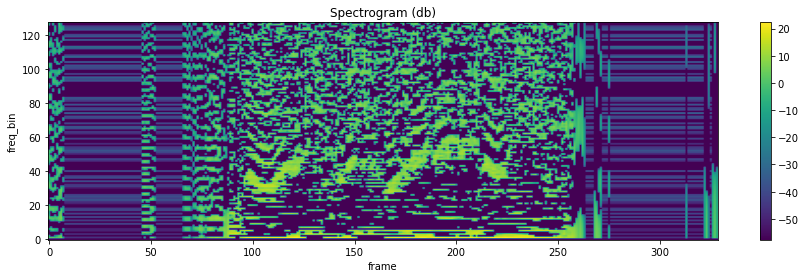

In [25]:
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    })

mfcc = mfcc_transform(waveform)

plot_spectrogram(mfcc[0])

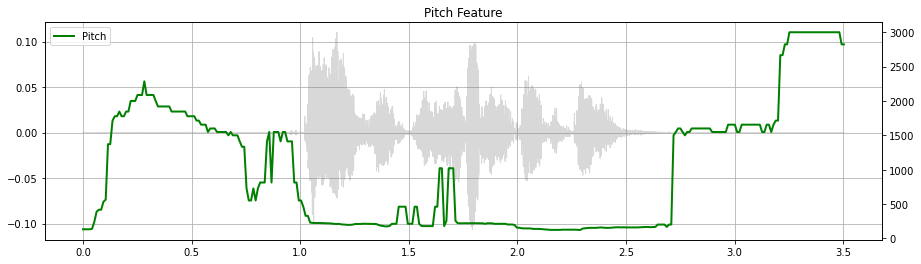

In [26]:
pitch = torchaudio.functional.detect_pitch_frequency(waveform, sample_rate)
plot_pitch(waveform, sample_rate, pitch)
play_audio(waveform, sample_rate)

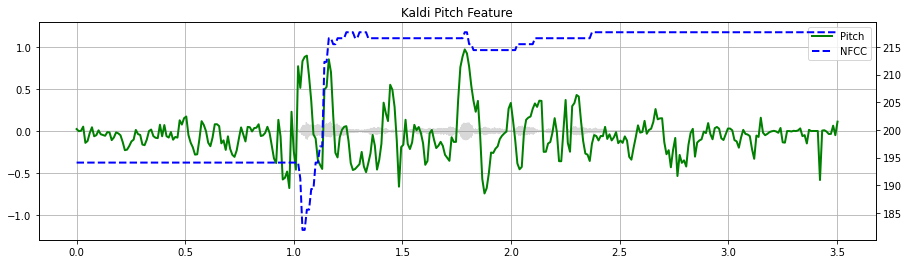

In [27]:
pitch_feature = torchaudio.functional.compute_kaldi_pitch(waveform, sample_rate)
pitch, nfcc = pitch_feature[..., 0], pitch_feature[..., 1]

plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc)
play_audio(waveform, sample_rate)

# Audio Feature Augmentation 
https://pytorch.org/tutorials/beginner/audio_feature_augmentation_tutorial.html

In [ ]:
import torchaudio.functional as F
import torchaudio.transforms as T

# creating a Pytorch dataframe odject


In [ ]:
from torch.utils.data import Dataset
# https://www.youtube.com/watch?v=88FFnqt5MNI&ab_channel=ValerioVelardo-TheSoundofAI